# Проверка гипотез с помощью A/B-тестирования

# Введение

**Проект направлен** на подтверждение/опровержение гипотез по увеличению выручки интернет-магазина.

**Цель исследования**:

* Провести приоритизацию гипотез с использованием фреймворков ICE и RICE;
* Проанализировать результаты инициированного A/B-тестирования;
* Сделать выводы по исследуемым параметрам и принять решение по продолжению/остановке тестирования.

**Описание исходных данных:**

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина, результаты проведенного A/B-теста описаны в файлах /datasets/orders.csv и /datasets/visitors.csv

Структура hypothesis.csv:
* *Hypothesis* — краткое описание гипотезы;
* *Reach* — охват пользователей по 10-балльной шкале;
* *Impact* — влияние на пользователей по 10-балльной шкале;
* *Confidence* — уверенность в гипотезе по 10-балльной шкале;
* *Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Структура orders.csv:
* *transactionId* — идентификатор заказа;
* *visitorId* — идентификатор пользователя, совершившего заказ;
* *date* — дата, когда был совершён заказ;
* *revenue* — выручка заказа;
* *group* — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
* *date* — дата;
* *group* — группа A/B-теста;
* *visitors* — количество пользователей в указанную дату в указанной группе A/B-теста.

**Исследование пройдет в 4 основных этапа:**

 * Обзор исходных данных;
 * Предобработка исходных данных;
 * Приоритизация гипотез;
 * Анализ A/B теста.

# Содержание <a id="Содержание"></a>

1. [Обзор исходных данных](#Обзор-исходных-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Приоритизация гипотез](#Приоритизация-гипотез)
    * [Применение фреймворка ICE](#Фреймворк-ICE)
    * [Применение фреймворка RICE](#Фреймворк-RICE)
    * [Разница в приоритизации](#Разница-в-приоритизации)
4. [Анализ A/B-теста](#Анализ-теста)
    * [График кумулятивной выручки по группам](#График-кумулятивной-выручки-по-группам)
    * [График кумулятивного среднего чека по группам](#График-кумулятивного-среднего-чека-по-группам)
    * [График кумулятивного среднего чека группы B к группе A](#График-кумулятивного-среднего-чека-группы-B-к-группе-A)
    * [График кумулятивного среднего количества заказов на посетителя](#График-кумулятивного-среднего-количества-заказов-на-посетителя)
    * [График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#График-относительного-изменения-кумулятивного-среднего-количества-заказов-на-посетителя-группы-B-к-группе-A)
    * [Точечный график количества заказов по пользователям](#Точечный-график-количества-заказов-по-пользователям)
    * [Перцентили количества заказов на пользователя](#Перцентили-количества-заказов-на-пользователя)
    * [Точечный график стоимостей заказов](#Точечный-график-стоимостей-заказов)
    * [Перцентили стоимости заказов](#Перцентили-стоимости-заказов)
    * [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«сырым»-данным)
    * [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#Статистическая-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«сырым»-данным)
    * [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«очищенным»-данным)
    * [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#Статистическая-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«очищенным»-данным)
    * [Необходимость продолжения тестирования](#Необходимость-продолжения-тестирования)
5. [Общий вывод](#Общий-вывод)

<a id='Обзор-исходных-данных'></a>
## Обзор исходных данных

In [1]:
#импортируем необходимые для проекта библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import math

#для полного отображения гипотез в таблицах снимем ограничения по длине отображаемых значений
pd.set_option('display.max_colwidth', 500)

In [2]:
#сохраним датасеты в дф
hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                                pd.read_csv('/datasets/orders.csv'),
                                pd.read_csv('/datasets/visitors.csv'))

Проверим предложенные данные:

In [3]:
#поскольку у нас 3 дф определим функцию для оптимизации
#(откажемся от цикла, чтобы была возможность текстово описать каждый отдельный результат вывода)
def data_info(data):
    '''
    Аргумент функции - название датасета.
    Функция выводит первые 5 строк датасета, информацию по нему и гистограммы по числовым столбцам.
    '''
    display(data.head(9))
    data.info()
    data.hist(figsize=(15, 5))
    plt.show()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


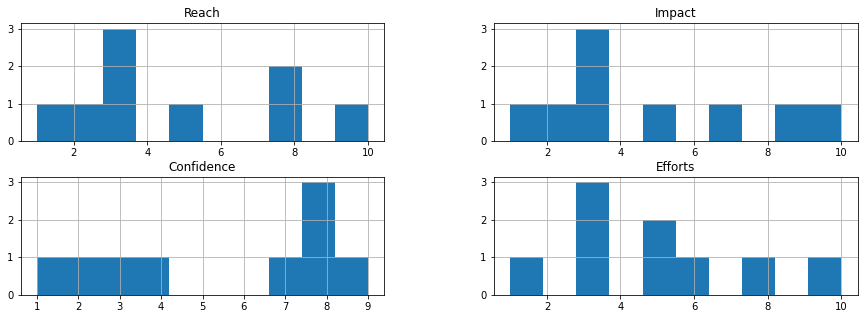

In [4]:
data_info(hypothesis)

Тип данных в порядке, пропусков нет, аномальных значений тоже, необходимо привести названия столбцов к нижнему регистру (также выявлено отсутствие неявных дубликатов). 

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


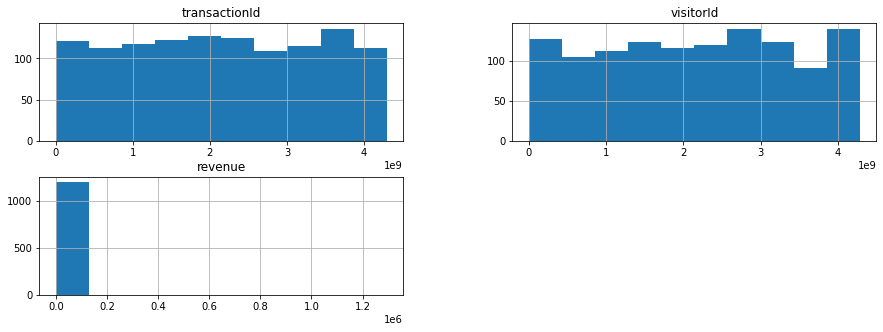

In [5]:
data_info(orders)

Пропусков нет, аномальных значений не замечено, необходимо привестипу колонку date к типу datetime. 

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


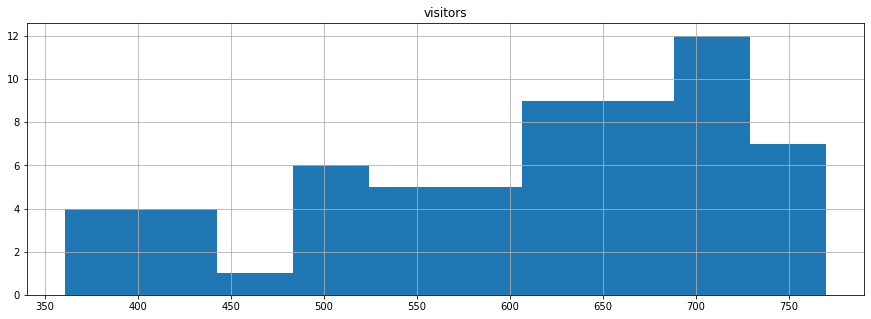

In [6]:
data_info(visitors)

Пропусков нет, аномальных значений не замечено, необходимо привестипу колонку date к типу datetime. 

В связи с проведением A/B-теста убедимся в отсутствии пересечений по пользователям в сформированных группах для точности исследования:

In [7]:
#создадим таблицу со сгруппированными пользователями и агрегированными показателями, 
#включая количество групп, в которых он находится
overlap = orders.groupby(['visitorId']).agg({'group' : 'nunique', 'transactionId' : 'count', 'revenue' : 'sum'}).reset_index()
print(f'Количество пересекающихся пользователей: {overlap[overlap["group"] != 1]["visitorId"].count()}')

Количество пересекающихся пользователей: 58


Видим, что есть пользователи, находящиеся сразу в двух группах. 

**Вывод:**

Мы провели первичный обзор данных, не было выявлено пропусков, необходимо изменить тип данных в столбцах с датами, исправить наименования столбцов и убрать пересекающихся пользователей по группам из выборки. 

[Вернуться к содержанию](#Содержание)

<a id="Предобработка-данных"></a>
## Предобработка данных

Сначала решим проблему с наименованиями столбцов:

In [8]:
for i in [hypothesis, orders]:
    i.columns = (j.lower() for j in i.columns)

Изменим тип данных в столбцах с датами:

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим изменения:

In [10]:
for i in [hypothesis, orders, visitors]:
    display(i.head(3))
    print(i.info())
    print()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None



,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None



Названия и тип данных корректны. 

Проверим наши данные на наличие дубликатов. Начнем с явных:

In [11]:
data_list = {'hypothesis':hypothesis, 'orders':orders, 'visitors':visitors}

for name, df in data_list.items():
    print(f'Количество дубликатов в {name}:', df.duplicated().sum())
    df = df.drop_duplicates() 
    if name == 'visits':
        visits = df
    elif name == 'orders':
        orders = df
    elif name == 'costs':
        costs = df
    print(f'Количество дубликатов в {name} после обработки:', df.duplicated().sum())
    print()

Количество дубликатов в hypothesis: 0
Количество дубликатов в hypothesis после обработки: 0

Количество дубликатов в orders: 0
Количество дубликатов в orders после обработки: 0

Количество дубликатов в visitors: 0
Количество дубликатов в visitors после обработки: 0



Явных дубликатов не выявлено, поищем неявные - они могут быть в столбцах с обозначением групп и :

In [12]:
#проверим уникальные значения в обозначенных столбцах
for i in [orders['group'], visitors['group']]:
    print(f'Количество уникальных значений {i.name}:', i.nunique(), '\n',
          i.sort_values().unique())
    print()

Количество уникальных значений group: 2 
 ['A' 'B']

Количество уникальных значений group: 2 
 ['A' 'B']



Неявных дубликатов не выявлено.

Исправим ситуацию с пересекающимися по группам пользователями:

In [13]:
#для удобства также приведем к нижнему регистру названия столбцов в пограничной таблице с пользваотелями 
overlap.columns = (j.lower() for j in overlap.columns)
#создаем список пересекающихся пользователей
overlap_users = overlap[overlap['group'] != 1]['visitorid']
#создаем новый дф orders без пользователей из списка
orders_no_overlap = orders[~orders['visitorid'].isin(overlap_users)].reset_index(drop=True)
#проверим отсутствие пересекающихся пользователей
orders_no_overlap_check = orders_no_overlap.groupby(['visitorid'])\
.agg({'group':'nunique', 'transactionid':'count', 'revenue':'sum'}).reset_index()

print(f'Количество пересекающихся пользователей:\
{orders_no_overlap_check[orders_no_overlap_check["group"] != 1]["visitorid"].count()}')

Количество пересекающихся пользователей:0


**Вывод:**

Мы провели предобработку данных:

* Названия столбцов и типы их данных приведены стандарту;
* Дубликаты в датафреймах не выявлены;
* Записан новый датафрейм с пользователями без пересечения по группам. 

[Вернуться к содержанию](#Содержание)

<a id='Приоритизация-гипотез'></a>
## Приоритизация гипотез

У нас есть список из 9 гипотез для повышения выручки интернет-магазина.

<a id='Фреймворк-ICE'></a>
Применим фреймворк ICE для приоритизации гипотез:

In [14]:
#Рассчитаем рейтинг гипотез по формуле для ICE 
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
#Выведем таблицу рейтинга
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Согласно ICE наиболее приоритетной гипотезой стала 8-я: запустить акцию, дающую скидку на товар в день рождения.

<a id='Фреймворк-RICE'></a>
Посмотрим, как распределятся гипотезы по рейтингу при применении фреймворка RICE:

In [15]:
#Рассчитаем рейтинг гипотез по формуле для RICE 
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
#Выведем таблицу рейтинга
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Согласно RICE наиболее приоритетной гипотезой с отрывом по количеству очков в 2 раза (56 очков) от 2-го места стала 7-я: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

<a id='Разница-в-приоритизации'></a>
Сравним результаты после расчета рейтинга приоритета гипотез по ICE и RICE:

In [16]:
#сформируем сравнительную таблицу с рангами
hypothesis_rating = hypothesis[['hypothesis']].copy()
hypothesis_rating['ice'] = hypothesis['ice'].rank(ascending=False).astype(int)
hypothesis_rating['rice'] = hypothesis['rice'].rank(ascending=False).astype(int)
hypothesis_rating = hypothesis_rating.sort_values(by=['ice', 'rice'], ascending=True)
#добавим столбец с разницей в рангах
hypothesis_rating['rank_diff'] = hypothesis_rating['ice'] - hypothesis_rating['rice']
hypothesis_rating

,hypothesis,ice,rice,rank_diff
8,"Запустить акцию, дающую скидку на товар в день рождения",1,5,-4
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2,3,-1
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",3,1,2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",4,3,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",5,2,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6,7,-1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7,7,0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,6,2
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9,9,0


Видим изменения в рейтингах гипотез при разных подходах к их приоритизации. Так произошло в связи с тем, что при RICE учитывается Reach в расчетах, который обозначает аудиторию проводимых изменений. 

**Вывод:**

Мы провели приоритизацию гипотез:

* При ICE первое место заняла 8-я гипотеза;
* При RICE первое место заняла 7-я гипотеза;
* Если учитывать совокупный рейтинг, наиболее приоритетными гипотезами стали 0-я и 7-я гипотезы, которые в обоих рейтингах являются топ-3. 

[Вернуться к содержанию](#Содержание)

<a id='Анализ-теста'></a>
## Анализ A/B-теста

В нашем распоряжении результаты A/B-тестирования, которые необходимо проанализировать и интерпретировать. 

Датафреймы orders_no_overlap и visitors содержат информацию о заказах и посетителях интернет-магазина, полученные в рамках A/B-тестирования. Получим новый датасет, содержащий кумулятивные данные:

In [17]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders_no_overlap[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах
orders_agg = dates_groups.apply(lambda x: orders_no_overlap[np.logical_and(orders_no_overlap['date'] <= x['date'],\
orders_no_overlap['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique',\
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
data_c = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
data_c.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

data_c.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


<a id='График-кумулятивной-выручки-по-группам'></a>
Построим **график кумулятивной выручки** по группам:

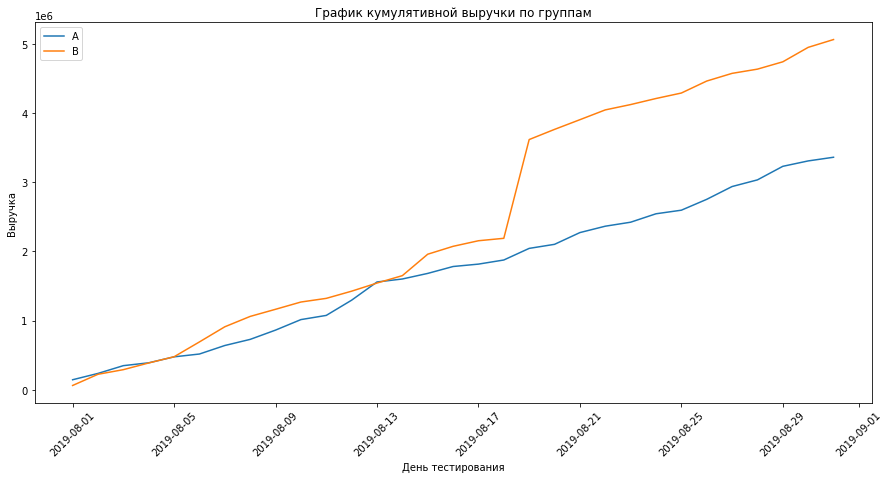

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
revenue_a_c = data_c[data_c['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
revenue_b_c = data_c[data_c['group']=='B'][['date','revenue', 'orders']]

#зададим размер графика для сабплотов
plt.figure(figsize=(15, 7))

# Строим график выручки группы А
plt.plot(revenue_a_c['date'], revenue_a_c['revenue'], label='A')

# Строим график выручки группы B
plt.plot(revenue_b_c['date'], revenue_b_c['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xlabel("День тестирования")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Мы видим, что выручка в обеих группах увеличивается в течение всего теста. 18.08.2019 в группе B происходит скачок показателя вверх, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

<a id='График-кумулятивного-среднего-чека-по-группам'></a>
Построим **график кумулятивного среднего чека** по группам:

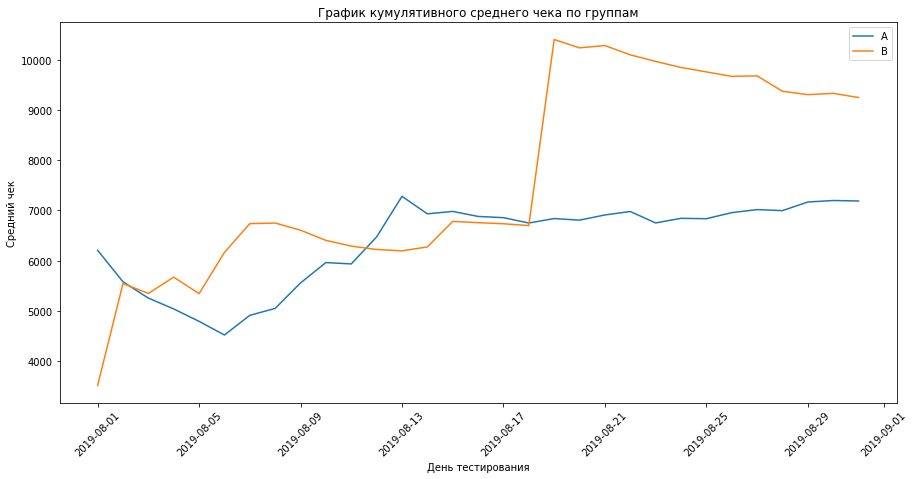

In [19]:
plt.figure(figsize=(15, 7))

#разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(revenue_a_c['date'], revenue_a_c['revenue']/revenue_a_c['orders'], label='A')
plt.plot(revenue_b_c['date'], revenue_b_c['revenue']/revenue_b_c['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Средний чек")
plt.xlabel("День тестирования")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Средний чек по группе A стабилизируется, начиная с 14.08.2019, по группе B мы наблюдаем тот же скачок, что и по выручке - значит, скорее всего, дело в 1 дорогостоящем заказе. 

<a id='График-кумулятивного-среднего-чека-группы-B-к-группе-A'></a>
Построим **график относительного изменения кумулятивного среднего чека группы B к группе A**:

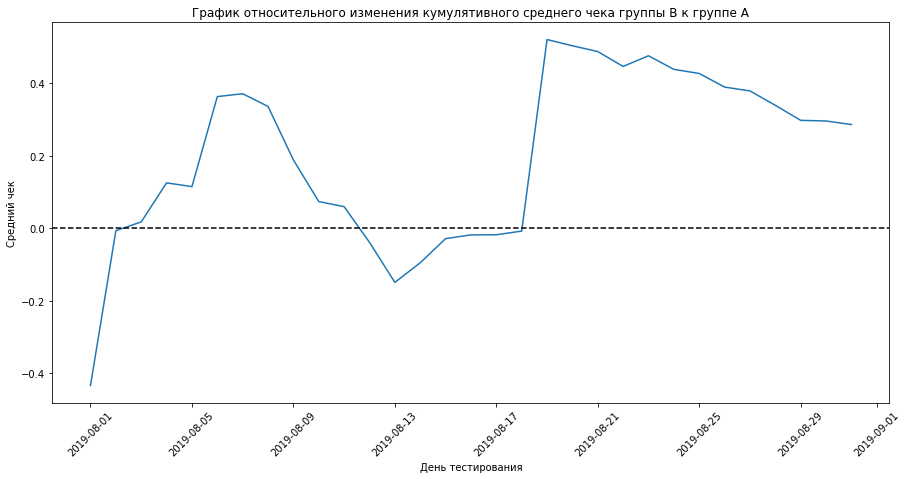

In [20]:
# собираем данные в одном датафрейме
merged_revenue_c = revenue_a_c.merge(revenue_b_c, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))

# cтроим отношение средних чеков
plt.plot(merged_revenue_c['date'], (merged_revenue_c['revenueB'] / merged_revenue_c['ordersB'])\
/ (merged_revenue_c['revenueA'] / merged_revenue_c['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel("Средний чек")
plt.xlabel("День тестирования")
plt.xticks(rotation=45)
plt.show()

В нескольких точках график различия между сегментами резко «скачет», что тоже может обозначать выбросы. 18.08.2019 наблюдаем знакомый скачок вверх. 

<a id='График-кумулятивного-среднего-количества-заказов-на-посетителя'></a>
Построим **график кумулятивного среднего количества заказов на посетителя** по группам:

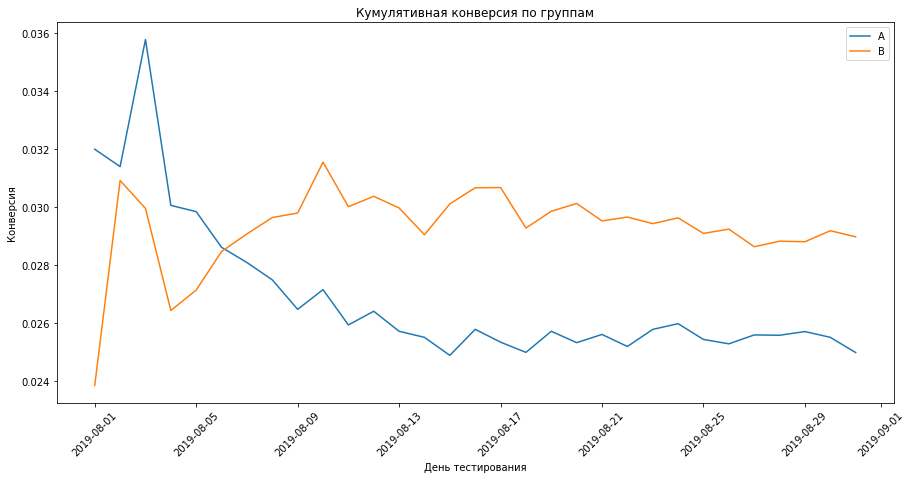

In [21]:
# считаем среднее количество заказов на посетителя
data_c['conversion'] = data_c['orders']/data_c['visitors']

# отделяем данные по группе A
data_a_c = data_c[data_c['group']=='A']

# отделяем данные по группе B
data_b_c = data_c[data_c['group']=='B']

plt.figure(figsize=(15, 7))

# строим графики
plt.plot(data_a_c['date'], data_a_c['conversion'], label='A')
plt.plot(data_b_c['date'], data_b_c['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('День тестирования')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)
plt.show()

Групповые кумулятивные показатели средего количества заказов на посетителя стартовали с разных значений и выравниваются примерно с 10 дня тестирования, где конверсия группы B стабильно выше конверсии группы A. 

<a id='График-относительного-изменения-кумулятивного-среднего-количества-заказов-на-посетителя-группы-B-к-группе-A'></a>
Постройте **график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**:

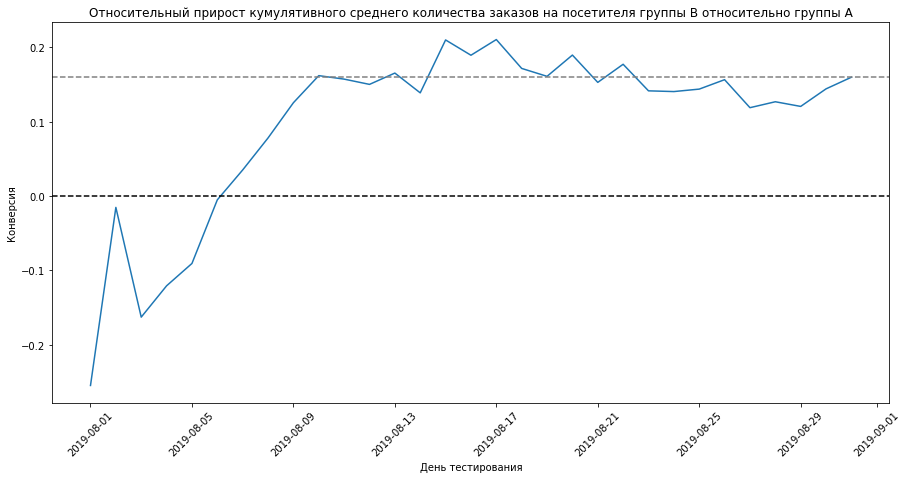

In [22]:
merged_conversions_c = data_a_c[['date','conversion']].merge(data_b_c[['date','conversion']],\
left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))
plt.plot(merged_conversions_c['date'], merged_conversions_c['conversionB']/merged_conversions_c['conversionA']-1)
plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A')
plt.xlabel('День тестирования')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.show()

Мы видим, что в первые 6 дней группа B проигрывала группе A по среднему количеству заказов на посетителя, благодаря росту, начиная с 3-го дня тестирования, группа В вышла вперед 06.08.2019. Стабилизация кумулятивного показателя произошла около 10 дня тестирования, что мы и видели на предыдущем графике по группам. 

<a id='Точечный-график-количества-заказов-по-пользователям'></a>
Построим **точечный график количества заказов по пользователям**:

In [23]:
#сформируем таблицу с количеством заказов на пользователя 
orders_by_users = (orders_no_overlap.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
orders_by_users.columns = ['visitorid', 'transactionid']

orders_by_users.head()

,visitorid,transactionid
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


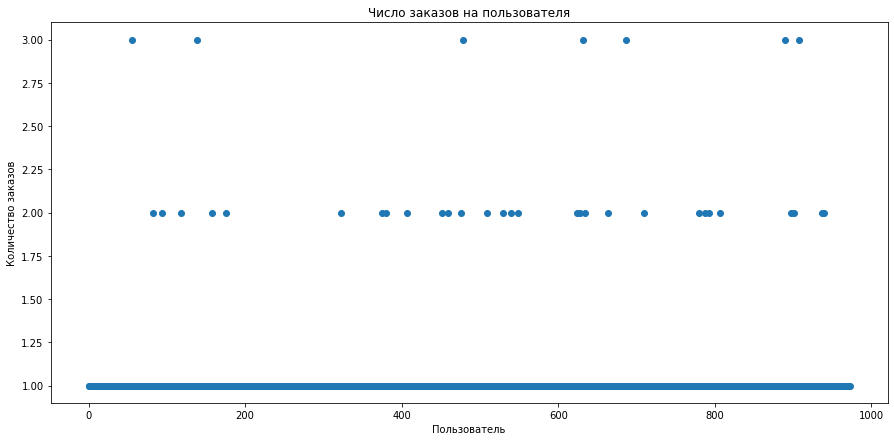

In [24]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, orders_by_users['transactionid'])
plt.title('Число заказов на пользователя')
plt.xlabel('Пользователь')
plt.ylabel('Количество заказов')
plt.show()

В основном пользователи делали по 1 заказу, есть пользователи, сделавшие по 2-3 заказа - эти точки выбиваются из общей массы, ранее мы уже отмечали вероятное наличие выбросов/аномальных значений в данных по тестированию.

<a id='Перцентили-количества-заказов-на-пользователя'></a>
Посчитаем **95-й и 99-й перцентили количества заказов на пользователя**:

In [25]:
print(np.percentile(orders_by_users['transactionid'], [95, 99]))

[1. 2.]


Не более 1% пользователей оформляли 2 и более заказа.
Разумно выбрать 1 заказ на одного пользователя за верхнюю границу числа заказов - выше аномальные значения.

<a id='Точечный-график-стоимостей-заказов'></a>
Построим **точечный график стоимостей заказов**:

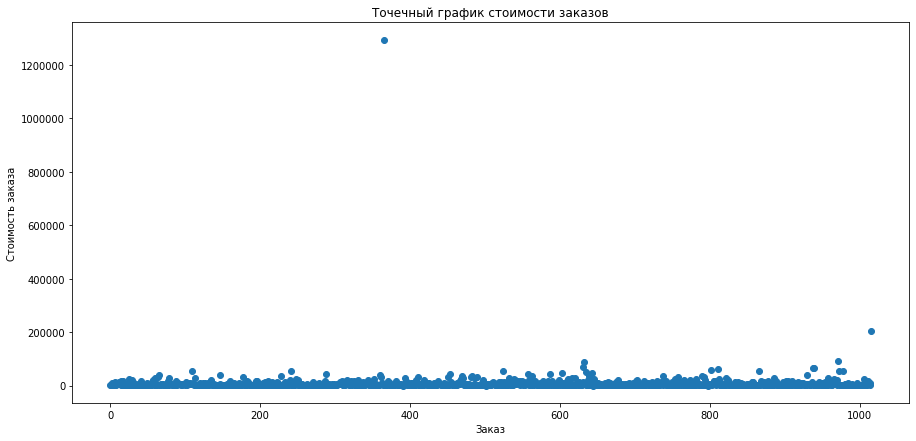

In [26]:
x_values = pd.Series(range(0,len(orders_no_overlap['revenue'])))

plt.figure(figsize=(15, 7))
plt.ticklabel_format(style='plain')
plt.scatter(x_values, orders_no_overlap['revenue'])
plt.title('Точечный график стоимости заказов')
plt.xlabel('Заказ')
plt.ylabel('Стоимость заказа')
plt.show()

Видим 2 отчетливых выброса: один на 1200000, другой на 20000. Ранее мы фиксировали значительный скачок в кумулятивной выручке группы В с 18.08.2019 по 19.08.2019, теперь мы отчетливо видим причину. 

<a id='Перцентили-стоимости-заказов'></a>
Посчитаем **95-й и 99-й перцентили стоимости заказов**:

In [27]:
print(np.percentile(orders_no_overlap['revenue'], [95, 99]))

[26785. 53904.]


Не более 1 процента заказов имеют сумму более 53904 - под эту планку попадают 2 найденных ярко выраженных выброса. 

<a id='Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«сырым»-данным'></a>
Посчитаем **статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**:

In [28]:
#выясним общую конверсию по группам
conversion_raw = orders_no_overlap.groupby('group').agg({'transactionid':'count'}).join(visitors.groupby('group')\
.agg({'visitors':'sum'})).reset_index()
              
conversion_raw['conversion'] = conversion_raw['transactionid'] / conversion_raw['visitors']
conversion_raw

,group,transactionid,visitors,conversion
0,A,468,18736,0.024979
1,B,548,18916,0.028970


У нас есть значение конверсий для неочищенных выборрок (групп), выясним, можем ли мы доверять результату и судить по нему о генеральной совокупности.

Сформулируем гипотезы:

H0: Конверсия по двум группам равна;

H1: Конверсия по двум группам не равна. 

In [29]:
#поскольку конверсия - это коэффициент, процентная доля, будем использовать критерий Z для оценки стат. значимости
alpha = .05 # критический уровень статистической значимости
successes = conversion_raw['transactionid']
trials = conversion_raw['visitors']
# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
#разница пропорций в датасетах
difference = p1 - p2
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.016851380434703023
Отвергаем нулевую гипотезу: между долями есть значимая разница


Таким образом, по неочищенным данным конверсия группы B выше конверсии группы А на 0.4%, разница статистически значима. 

<a id='Статистическая-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«сырым»-данным'></a>
Посчитаем **статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**:

Ранее мы уже формировали график со средним чеком и наблюдали выброс (18-го числа), проверим, является ли различие в среднем чеке между группами статистически значимым:

In [30]:
#выведем средний чек по всем данным
print('Средний чек по группе А:', orders_no_overlap[orders_no_overlap['group']=='A']['revenue'].mean())
print('Средний чек по группе В:', orders_no_overlap[orders_no_overlap['group']=='B']['revenue'].mean())

Средний чек по группе А: 7189.4358974358975
Средний чек по группе В: 9249.94890510949


Видим разницу, определим, можем ли мы считать ее статистически значимой.

Сформулируем гипотезы:

H0: Средний чек заказа по двум группам не различается;

H1: Средний чек заказа по двум группам различается. 

In [31]:
#поскольку это сырые данные с аномальными значениями и не доли, как в прошлом показателе, 
#будем использовать критерий Манна-Уитни, передадим тесту сами данные, а не агрегированные значения среднего чека,
#т.к. тест рассчитан на сравнение ранговых данных между выборками
alpha = .05 # критический уровень статистической значимости
results = st.mannwhitneyu(orders_no_overlap[orders_no_overlap['group']=='A']['revenue'],\
                          orders_no_overlap[orders_no_overlap['group']=='B']['revenue'])
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.8294908998149533
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Таким образом, по различиям в среднем чеке двух групп теста нельзя утверждать того же о данных генеральной совокупности, так как вероятность случайно наблюдать такую разницу при условии, что средние чеки на самом деле равны, достаточно высока - 73%. Это значительно выше уровня значимости в 5%, поэтому нельзя отвергнуть нулевую гипотезу — разница в среднем чеке не является статистически значимой.

<a id='Статистическая-значимость-различий-в-среднем-количестве-заказов-на-посетителя-между-группами-по-«очищенным»-данным'></a>
Посчитаем **статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным**:

In [32]:
#сначала отфильтруем данные от ранее найденных выбросов: не более 3х заказов на посетителя и стоимость заказа не более 58233
orders_filtered = orders_no_overlap[((orders_no_overlap['revenue']<=53904)) & (orders_no_overlap['visitorid']\
.isin(orders_by_users[(orders_by_users['transactionid']<=1)]['visitorid'].to_list()))]

conversion_filtered = (orders_filtered.groupby('group').agg({'transactionid':'count'}).join(visitors.groupby('group')\
.agg({'visitors':'sum'})).reset_index())
conversion_filtered['conversion'] = conversion_filtered['transactionid'] / conversion_filtered['visitors']
conversion_filtered

,group,transactionid,visitors,conversion
0,A,422,18736,0.022523
1,B,506,18916,0.026750


Видим, что по очищенным данным конверсия относительно друг друга не сильно изменилась (вновь разница около 0.4%). 
Проверим, являются ли эти значения статистически значимыми:

H0: Конверсия по двум группа равна;

H1: Конверсия по двум группам не равна. 

In [33]:
#поскольку конверсия - это коэффициент, процентная доля, будем использовать критерий Z для оценки стат. значимости
alpha = .05 # критический уровень статистической значимости
successes = conversion_filtered['transactionid']
trials = conversion_filtered['visitors']
# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
#разница пропорций в датасетах
difference = p1 - p2
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.008178114125688918
Отвергаем нулевую гипотезу: между долями есть значимая разница


Различия в среднем количестве заказов на поситителя вновь стат. значимы.

<a id='Статистическая-значимость-различий-в-среднем-чеке-заказа-между-группами-по-«очищенным»-данным'></a>
Посчитаем **статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным**:

In [34]:
#выведем значения среднего чека по очищенным данным 
print('Средний чек по группе А:', orders_filtered[orders_filtered['group']=='A']['revenue'].mean())
print('Средний чек по группе В:', orders_filtered[orders_filtered['group']=='B']['revenue'].mean())

Средний чек по группе А: 6371.995260663507
Средний чек по группе В: 6387.217391304348


Видим, что, убрав выбросы, значения среднего чека по группам приблизились друг к другу.
Проверим, можем ли мы считать этот результат статистически значимым:

H0: Средний чек заказа по двум группам не различается;

H1: Средний чек заказа по двум группам различается.

In [35]:
alpha = .05
results = st.mannwhitneyu(orders_filtered[orders_filtered['group']=='A']['revenue'],
                          orders_filtered[orders_filtered['group']=='B']['revenue'])
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.9694915845343968
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Исход аналогичен расчетам по сырым данным.

<a id='Необходимость-продолжения-тестирования'></a>
Выясним, **есть ли необходимость в продлении тестирования**:

Исходя из вычислений выше: рекомендуется остановить тестирование и признать победу группы B, так как среднее количество заказов на посетителя(конверсия) у этой группы стабилизировалась и располагается выше, чем у группы А, аналогично и с другими показателями (в случае со средним чеком показатель группы В без выбросов ниже, однако разница не стат. значима).

При варианте продолжения тестирования есть риск впустую потраченных средств, когда кривые стабилизируются без выбросов и превосходство группы В будет очевидно по всем ключевым параметрам. 

**Вывод:**

Мы провели анализ A/B-теста:

* Группа В обогнала группу А по всем показателям;
* Показатели стоимости заказа свыше 53904 и количество заказов более 1 на посетителя признаны аномальными;
* Группа В незначительно уступает группе А по всем показателям, кроме конверсии, если учитывать очищенные данные;
* Разница в конверсии между группами является стат значимой;
* Разница в среднем чеке не является стат. значимой;
* Рекомендовано остановить тестирование и признать победу группы В.

[Вернуться к содержанию](#Содержание)

<a id="Общий-вывод"></a>
## Общий вывод

**Приоритизация гипотез:**

* При ICE первое место заняла 8-я гипотеза;
* При RICE первое место заняла 7-я гипотеза;
* Если учитывать совокупный рейтинг, наиболее приоритетными гипотезами стали 0-я и 7-я гипотезы, которые в обоих рейтингах являются топ-3.


**A/B-тестирование:**

* Группа В обогнала группу А по всем показателям;
* Группа В незначительно уступает группе А по показателю среднего чека (А: 6371.9, В: 6387.2), если учитывать очищенные данные;
* Разница в конверсии между группами является стат значимой;
* Разница в среднем чеке не является стат. значимой;
* Рекомендовано остановить тестирование и признать победу группы В.

[Вернуться к содержанию](#Содержание)